### Performing the initial setup by importing all necessary libraries and loading API credentials from .env file. It ensures all dependencies and configurations are properly loaded.


In [2]:
import pandas as pd
import numpy as np
import requests
import json
import os
from dotenv import load_dotenv
import folium
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
from geopy.distance import geodesic
import warnings
import joblib
from folium.plugins import MarkerCluster, AntPath
import polyline
warnings.filterwarnings('ignore')

load_dotenv()

MAPMYINDIA_API_KEY = os.getenv('MAPMYINDIA_API_KEY')
WEATHER_API_KEY = os.getenv('WEATHER_API_KEY')
GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

print("Environment loaded successfully!")

Environment loaded successfully!


### Loading the Starbucks Mumbai location dataset from an excel file from /route_optimizer/data and performs initial data cleaning to prepare it for further analysis. It ensures all location records have valid coordinates and creates a standardized structure for further processing.

In [3]:
df = pd.read_excel('../data/Starbucks_Mumbai_Dataset.xlsx')

print(f"Dataset shape: {df.shape}")
print("\nDataset columns:")
print(df.columns.tolist())

df = df.dropna(subset=['Latitude', 'Longitude'])
df['store_id'] = df.index

df_clean = df[['store_id', 'Store Name', 'Latitude', 'Longitude', 
               'Street Address', 'City', 'State']].copy()

print(f"\nCleaned dataset shape: {df_clean.shape}")
print("\nSample locations:")
df_clean.head()


Dataset shape: (32, 13)

Dataset columns:
['Brand', 'Store Number', 'Store Name', 'Ownership Type', 'Street Address', 'City', 'State', 'Country', 'Pincode', 'Phone Number', 'Timezone', 'Longitude', 'Latitude']

Cleaned dataset shape: (32, 7)

Sample locations:


,store_id,Store Name,Latitude,Longitude,Street Address,City,State
0,0,Prabhadevi,19.01,72.82,"Upper Ground Floor, Century Bhavan, Century Ba...",Mumbai,MH
1,1,Malad West - Infiniti Mall,19.18,72.83,"Upper Ground Floor, Infiniti Mall, Link Road, ...",Mumbai,MH
2,2,Santacruz West,19.08,72.83,"Grd Flr Red Chillies Entertainment Bldg, Jct o...",Mumbai,MH
3,3,Nariman Point,18.93,72.82,"Ground Floor, Shree Nirmal Building, Behind Tr...",Mumbai,MH
4,4,Andheri West - Four Bunglows,19.13,72.82,"Kokilaben Dhirubhai Ambani Hospital, Four Bung...",Mumbai,MH


### Implements geocoding functionality to ensure all locations have valid geographic coordinates. It addresses data quality issues by using MapMyIndia's Geocoding API to convert street addresses into latitude/longitude pairs for any locations with missing or invalid coordinates.

In [4]:
def mapmyindia_geocode(address):
    base_url = "https://apis.mapmyindia.com/advancedmaps/v1"
    endpoint = f"{base_url}/{MAPMYINDIA_API_KEY}/geocode"
    
    params = {
        'address': address,
        'region': 'IND',
        'maxResults': 1
    }
    
    try:
        response = requests.get(endpoint, params=params, timeout=10)
        if response.status_code == 200:
            data = response.json()
            if data.get('copResults') and len(data['copResults']) > 0:
                result = data['copResults'][0]
                return {
                    'lat': float(result.get('latitude', 0)),
                    'lng': float(result.get('longitude', 0)),
                    'formatted_address': result.get('formattedAddress', ''),
                    'confidence': result.get('confidenceScore', 0)
                }
    except Exception as e:
        print(f"MapMyIndia geocoding error: {e}")
    
    return None

def validate_coordinates(df):
    """Validate and update coordinates using MapMyIndia if necessary"""
    updated_count = 0
    for idx, row in df.iterrows():
        if pd.isna(row['Latitude']) or pd.isna(row['Longitude']) or row['Latitude'] == 0:
            address = f"{row['Street Address']}, {row['City']}, {row['State']}, India"
            print(f"Geocoding: {address}")
            result = mapmyindia_geocode(address)
            if result and result['confidence'] > 0.7:
                df.at[idx, 'Latitude'] = result['lat']
                df.at[idx, 'Longitude'] = result['lng']
                updated_count += 1
                print(f"  Updated coordinates for {row['Store Name']}")
            time.sleep(0.5)  # API limits
    
    print(f"\nUpdated {updated_count} coordinates using MapMyIndia")
    return df

### Implements weather data fetching functionality to enrich the location analysis with real-time weather information. Weather conditions can significantly impact foot traffic and customer behavior at retail locations, making this data valuable for predictive modeling and insights.

In [ ]:
def get_weather_data(lat, lon):
    base_url = "http://api.weatherapi.com/v1/current.json"
    
    params = {
        'key': WEATHER_API_KEY,
        'q': f"{lat},{lon}",
        'aqi': 'yes'
    }
    
    try:
        response = requests.get(base_url, params=params, timeout=10)
        if response.status_code == 200:
            data = response.json()
            weather_info = {
                'temperature': data['current']['temp_c'],
                'humidity': data['current']['humidity'],
                'wind_speed': data['current']['wind_kph'],
                'condition': data['current']['condition']['text'],
                'visibility': data['current']['vis_km'],
                'precipitation': data['current']['precip_mm'],
                'feels_like': data['current']['feelslike_c'],
                'is_day': data['current']['is_day']
            }
            return weather_info
    except Exception as e:
        print(f"Weather API error: {e}")
    
    # Incase API fails
    return {
        'temperature': 28.0,
        'humidity': 75.0,
        'wind_speed': 10.0,
        'condition': 'Clear',
        'visibility': 10.0,
        'precipitation': 0.0,
        'feels_like': 30.0,
        'is_day': 1
    }

# Checking if API works
test_weather = get_weather_data(19.0760, 72.8777)
print("Weather API Test:")
print(f"Temperature: {test_weather['temperature']}°C")
print(f"Condition: {test_weather['condition']}")
print(f"Humidity: {test_weather['humidity']}%")
       

Weather API Test:
Temperature: 28.0°C
Condition: Clear
Humidity: 75.0%


### Implements functionality to calculate real-time driving distances and travel times between Starbucks locations, accounting for traffic conditions. This data is crucial for understanding accessibility, delivery zones, and customer catchment areas for each store location. Leverages Google's Distance Matrix API to get accurate travel metrics between two points

In [6]:
def get_travel_time_distance(origin_lat, origin_lon, dest_lat, dest_lon, departure_time='now'):
    base_url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    
    params = {
        'origins': f"{origin_lat},{origin_lon}",
        'destinations': f"{dest_lat},{dest_lon}",
        'mode': 'driving',
        'departure_time': departure_time,
        'traffic_model': 'best_guess',
        'key': GOOGLE_MAPS_API_KEY,
        'units': 'metric'
    }
    
    try:
        response = requests.get(base_url, params=params, timeout=10)
        if response.status_code == 200:
            data = response.json()
            if data['status'] == 'OK' and data['rows']:
                element = data['rows'][0]['elements'][0]
                if element['status'] == 'OK':
                    return {
                        'distance': element['distance']['value'] / 1000,  # km
                        'duration': element['duration']['value'] / 60,    # minutes
                        'duration_in_traffic': element.get('duration_in_traffic', {}).get('value', element['duration']['value']) / 60,
                        'status': 'success'
                    }
    except Exception as e:
        print(f"Distance Matrix API error: {e}")
    
    distance = geodesic((origin_lat, origin_lon), (dest_lat, dest_lon)).km
    return {
        'distance': distance,
        'duration': distance * 2.5, 
        'duration_in_traffic': distance * 3.0,  
        'status': 'fallback'
    }

# Checking if API works
test_result = get_travel_time_distance(19.0760, 72.8777, 19.1136, 72.8697)
print("\nDistance Matrix API Test:")
print(f"Distance: {test_result['distance']:.2f} km")
print(f"Duration: {test_result['duration']:.2f} minutes")
print(f"Duration in traffic: {test_result['duration_in_traffic']:.2f} minutes")
print(f"Status: {test_result['status']}")




Distance Matrix API Test:
Distance: 4.25 km
Duration: 10.62 minutes
Duration in traffic: 12.74 minutes
Status: fallback


### Deciding the starting point of our delivery

In [ ]:
# Gave starting pointing location of Mumbai Central
STARTING_POINT = {
    'name': 'Central Depot',
    'lat': 19.0760,  
    'lon': 72.8777,
    'address': 'Mumbai Central, Mumbai, Maharashtra'
}

print(f"Starting Point: {STARTING_POINT['name']}")
print(f"Coordinates: ({STARTING_POINT['lat']}, {STARTING_POINT['lon']})")


Starting Point: Central Depot
Coordinates: (19.076, 72.8777)


### Generates synthetic training data for a machine learning model that will predict travel times and distances between locations. It creates a diverse dataset of routes with real-time traffic and weather conditions, building the foundation for training the XGBoost model.

In [3]:
def generate_training_data(df_locations, starting_point, num_samples=500):
    training_data = []
    
    print(f"Generating {num_samples} training samples...")
    print("This includes routes from starting point and between locations...")
    
    for i in range(num_samples):
        route_type = np.random.choice(['location_to_location', 'from_start', 'to_start'], 
                                     p=[0.6, 0.2, 0.2])
        
        if route_type == 'location_to_location':
            origin_idx = np.random.randint(0, len(df_locations))
            dest_idx = np.random.randint(0, len(df_locations))
            
            if origin_idx == dest_idx:
                continue
            
            origin = df_locations.iloc[origin_idx]
            destination = df_locations.iloc[dest_idx]
            
            origin_lat = origin['Latitude']
            origin_lon = origin['Longitude']
            dest_lat = destination['Latitude']
            dest_lon = destination['Longitude']
            
        elif route_type == 'from_start':
            dest_idx = np.random.randint(0, len(df_locations))
            destination = df_locations.iloc[dest_idx]
            
            origin_lat = starting_point['lat']
            origin_lon = starting_point['lon']
            dest_lat = destination['Latitude']
            dest_lon = destination['Longitude']
            
        else:  
            origin_idx = np.random.randint(0, len(df_locations))
            origin = df_locations.iloc[origin_idx]
            
            origin_lat = origin['Latitude']
            origin_lon = origin['Longitude']
            dest_lat = starting_point['lat']
            dest_lon = starting_point['lon']
        
        weather = get_weather_data(origin_lat, origin_lon)
        travel_info = get_travel_time_distance(
            origin_lat, origin_lon,
            dest_lat, dest_lon
        )

        feature_dict = {
            'origin_lat': origin_lat,
            'origin_lon': origin_lon,
            'dest_lat': dest_lat,
            'dest_lon': dest_lon,
            'straight_line_distance': geodesic(
                (origin_lat, origin_lon),
                (dest_lat, dest_lon)
            ).km,
            'temperature': weather['temperature'],
            'humidity': weather['humidity'],
            'wind_speed': weather['wind_speed'],
            'visibility': weather['visibility'],
            'precipitation': weather['precipitation'],
            'hour_of_day': datetime.now().hour,
            'day_of_week': datetime.now().weekday(),
            'is_weekend': datetime.now().weekday() >= 5,
            'actual_distance': travel_info['distance'],
            'travel_time': travel_info['duration_in_traffic']
        }
        
        training_data.append(feature_dict)
        if (i + 1) % 50 == 0:
            print(f"  Generated {i + 1}/{num_samples} samples")
        if i % 10 == 0:
            time.sleep(0.5)
    
    return pd.DataFrame(training_data)

# Defined the starting point again, because of error
if 'STARTING_POINT' not in globals():
    STARTING_POINT = {
        'name': 'Central Depot',
        'lat': 19.0760,
        'lon': 72.8777,
        'address': 'Mumbai Central, Mumbai, Maharashtra'
    }

training_df = generate_training_data(df_clean, STARTING_POINT, num_samples=300)

training_df.to_csv('../data/training_data_with_traffic.csv', index=False)
print(f"\nTraining data shape: {training_df.shape}")
print("\nTraining data summary:")
training_df.describe()

NameError: name 'df_clean' is not defined

In [ ]:
X = training_df[feature_columns]
y = training_df['travel_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist'
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    early_stopping_rounds=20,
    verbose=False
)

y_pred = xgb_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))

print(f"\nModel Performance:")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f} minutes")
print(f"MAE: {mae:.2f} minutes")
print(f"Mean % Error: {(mae / y_test.mean() * 100):.1f}%")

os.makedirs('../models', exist_ok=True)
joblib.dump(xgb_model, '../models/xgboost_traffic_predictor.pkl')
joblib.dump(scaler, '../models/feature_scaler.pkl')
print("\nModel saved successfully!")

NameError: name 'training_df' is not defined

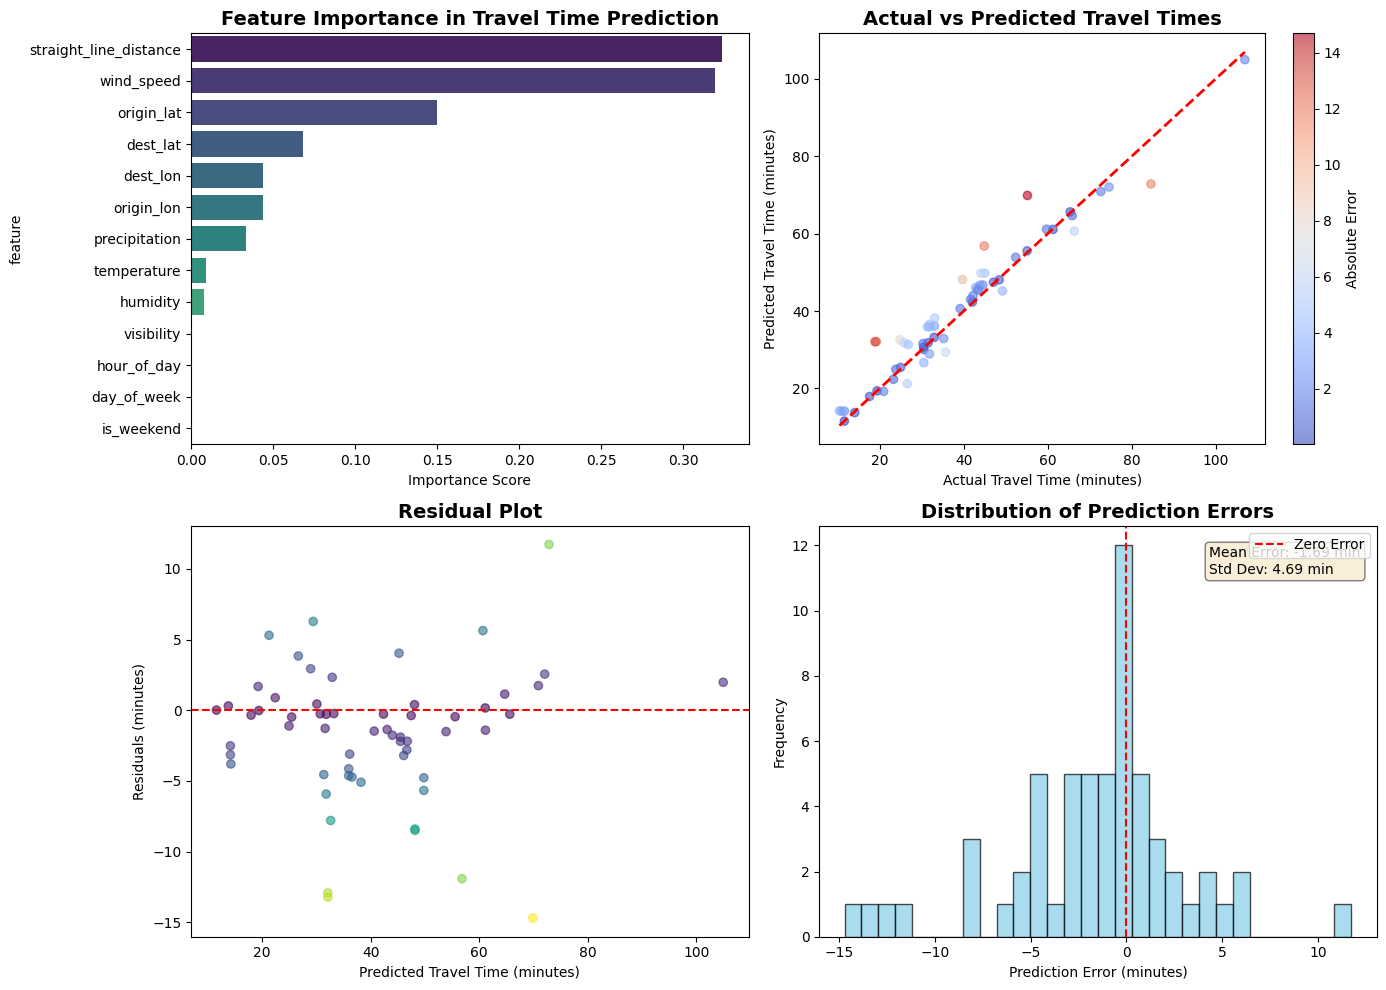

In [13]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Feature Importance
ax1 = axes[0, 0]
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance, x='importance', y='feature', ax=ax1, palette='viridis')
ax1.set_title('Feature Importance in Travel Time Prediction', fontsize=14, weight='bold')
ax1.set_xlabel('Importance Score')

# 2. Actual vs Predicted
ax2 = axes[0, 1]
scatter = ax2.scatter(y_test, y_pred, alpha=0.6, c=np.abs(y_test - y_pred), cmap='coolwarm')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Travel Time (minutes)')
ax2.set_ylabel('Predicted Travel Time (minutes)')
ax2.set_title('Actual vs Predicted Travel Times', fontsize=14, weight='bold')
plt.colorbar(scatter, ax=ax2, label='Absolute Error')

# 3. Residual Plot
ax3 = axes[1, 0]
residuals = y_test - y_pred
ax3.scatter(y_pred, residuals, alpha=0.6, c=np.abs(residuals), cmap='viridis')
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Predicted Travel Time (minutes)')
ax3.set_ylabel('Residuals (minutes)')
ax3.set_title('Residual Plot', fontsize=14, weight='bold')

# 4. Error Distribution
ax4 = axes[1, 1]
ax4.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(x=0, color='r', linestyle='--', label='Zero Error')
ax4.set_xlabel('Prediction Error (minutes)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Prediction Errors', fontsize=14, weight='bold')
ax4.legend()

# Add statistics text
stats_text = f'Mean Error: {np.mean(residuals):.2f} min\nStd Dev: {np.std(residuals):.2f} min'
ax4.text(0.7, 0.95, stats_text, transform=ax4.transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         verticalalignment='top')

plt.tight_layout()
plt.savefig('../data/xgboost_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### Predict travel time using XGBoost with real-time weather

In [ ]:
def predict_travel_time(origin_coords, dest_coords, model, scaler):
    
    # Get current weather
    weather = get_weather_data(origin_coords[0], origin_coords[1])
    
    # Calculate straight-line distance
    straight_distance = geodesic(origin_coords, dest_coords).km
    
    # Prepare features
    current_time = datetime.now()
    features = {
        'origin_lat': origin_coords[0],
        'origin_lon': origin_coords[1],
        'dest_lat': dest_coords[0],
        'dest_lon': dest_coords[1],
        'straight_line_distance': straight_distance,
        'temperature': weather['temperature'],
        'humidity': weather['humidity'],
        'wind_speed': weather['wind_speed'],
        'visibility': weather['visibility'],
        'precipitation': weather['precipitation'],
        'hour_of_day': current_time.hour,
        'day_of_week': current_time.weekday(),
        'is_weekend': current_time.weekday() >= 5
    }
    
    # Create feature array
    X = pd.DataFrame([features])[feature_columns]
    X_scaled = scaler.transform(X)
    
    # Predict
    predicted_time = model.predict(X_scaled)[0]
    
    # Apply weather-based adjustments
    if weather['condition'] in ['Heavy rain', 'Thunderstorm']:
        predicted_time *= 1.3  # 30% increase
    elif weather['condition'] in ['Rain', 'Light rain']:
        predicted_time *= 1.15  # 15% increase
    elif weather['visibility'] < 2:
        predicted_time *= 1.2  # 20% increase for poor visibility
    
    return predicted_time, weather

# Test prediction
test_origin = (19.0760, 72.8777)
test_dest = (19.1136, 72.8697)
pred_time, weather = predict_travel_time(test_origin, test_dest, xgb_model, scaler)
print(f"Predicted travel time: {pred_time:.2f} minutes")
print(f"Current weather: {weather['condition']}, {weather['temperature']}°C")
        

Predicted travel time: 25.87 minutes
Current weather: Mist, 29.4°C


### Creating a map showing all locations and starting point

In [ ]:
def create_locations_overview_map(df_locations, starting_point):
    
    # Calculate center
    all_lats = [starting_point['lat']] + list(df_locations['Latitude'])
    all_lons = [starting_point['lon']] + list(df_locations['Longitude'])
    center_lat = np.mean(all_lats)
    center_lon = np.mean(all_lons)
    
    # Create map
    overview_map = folium.Map(
        location=[center_lat, center_lon], 
        zoom_start=11,
        tiles='OpenStreetMap'
    )
    
    # Add starting point with special marker
    folium.Marker(
        location=[starting_point['lat'], starting_point['lon']],
        popup=folium.Popup(
            f"<b>{starting_point['name']}</b><br>"
            f"Type: Starting Point<br>"
            f"Address: {starting_point['address']}",
            max_width=300
        ),
        tooltip="Starting Point",
        icon=folium.Icon(color='red', icon='home', prefix='fa')
    ).add_to(overview_map)
    
    # Add circle around starting point
    folium.Circle(
        location=[starting_point['lat'], starting_point['lon']],
        radius=1000,  # 1km radius
        color='red',
        fill=True,
        fillColor='lightcoral',
        fillOpacity=0.2,
        weight=2
    ).add_to(overview_map)
    
    # Add delivery locations with clustering
    marker_cluster = MarkerCluster(name='Delivery Locations').add_to(overview_map)
    
    for idx, row in df_locations.iterrows():
        # Get current weather for each location
        weather = get_weather_data(row['Latitude'], row['Longitude'])
        
        # Determine icon color based on weather
        if weather['condition'] in ['Rain', 'Heavy rain', 'Thunderstorm']:
            color = 'darkred'
            weather_emoji = '🌧️'
        elif weather['condition'] in ['Cloudy', 'Overcast']:
            color = 'gray'
            weather_emoji = '☁️'
        else:
            color = 'green'
            weather_emoji = '☀️'
        
        popup_html = f"""
        <div style='font-family: Arial; width: 250px;'>
            <h4>{row['Store Name']}</h4>
            <hr>
            <b>Store ID:</b> {row['store_id']}<br>
            <b>Address:</b> {row['Street Address']}<br>
            <b>City:</b> {row['City']}<br>
            <b>Coordinates:</b> ({row['Latitude']:.4f}, {row['Longitude']:.4f})<br>
            <hr>
            <b>Current Weather {weather_emoji}</b><br>
            {weather['condition']}, {weather['temperature']}°C<br>
            Humidity: {weather['humidity']}%
        </div>
        """
        
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=f"{row['Store Name']} - {weather['condition']}",
            icon=folium.Icon(color=color, icon='coffee', prefix='fa')
        ).add_to(marker_cluster)
    
    return overview_map

# Create and display map
print("Creating overview map with all locations...")
overview_map = create_locations_overview_map(df_clean, STARTING_POINT)
print(f"Map created with {len(df_clean)} locations + starting point")
overview_map

            
          


Creating overview map with all locations...
Map created with 32 locations + starting point


### Creating distance matrix using XGBoost predictions

In [ ]:
def create_optimized_distance_matrix(locations, starting_point, model, scaler):
    
    # Include starting point as index 0
    n = len(locations) + 1
    distance_matrix = np.zeros((n, n))
    time_matrix = np.zeros((n, n))
    weather_conditions = {}
    
    print(f"Creating distance matrix for {n-1} locations + starting point...")
    print("Using XGBoost for travel time predictions with real-time traffic patterns...")
    
    # Get weather for starting point
    start_weather = get_weather_data(starting_point['lat'], starting_point['lon'])
    weather_conditions[0] = start_weather
    
    # Progress tracking
    total_calculations = n * n
    completed = 0
    
    for i in range(n):
        # Get origin coordinates
        if i == 0:
            origin_coords = (starting_point['lat'], starting_point['lon'])
        else:
            origin_coords = (locations.iloc[i-1]['Latitude'], locations.iloc[i-1]['Longitude'])
            weather = get_weather_data(origin_coords[0], origin_coords[1])
            weather_conditions[i] = weather
        
        for j in range(n):
            if i == j:
                distance_matrix[i][j] = 0
                time_matrix[i][j] = 0
            else:
                # Get destination coordinates
                if j == 0:
                    dest_coords = (starting_point['lat'], starting_point['lon'])
                else:
                    dest_coords = (locations.iloc[j-1]['Latitude'], locations.iloc[j-1]['Longitude'])
                
                # Use XGBoost to predict travel time
                predicted_time, _ = predict_travel_time(origin_coords, dest_coords, model, scaler)
                
                # Calculate distance
                distance = geodesic(origin_coords, dest_coords).km
                
                distance_matrix[i][j] = distance
                time_matrix[i][j] = predicted_time
            
            completed += 1
            if completed % 50 == 0:
                print(f"  Progress: {completed}/{total_calculations} calculations completed")
    
    print("Distance matrix created successfully!")
    return distance_matrix, time_matrix, weather_conditions

# Select locations for optimization
locations_subset = df_clean.head(10).reset_index(drop=True)

print("\nSelected locations for route optimization:")
for idx, row in locations_subset.iterrows():
    print(f"{idx + 1}: {row['Store Name']} - {row['Street Address']}")

# Create matrices
dist_matrix, time_matrix, weather_data = create_optimized_distance_matrix(
    locations_subset, STARTING_POINT, xgb_model, scaler
)





Selected locations for route optimization:
1: Prabhadevi - Upper Ground Floor, Century Bhavan, Century Bazaar, Prabhadevi
2: Malad West - Infiniti Mall - Upper Ground Floor, Infiniti Mall, Link Road,  Malad (West)
3: Santacruz West - Grd Flr Red Chillies Entertainment Bldg, Jct of 15th Rd and Ram Krishna MissionRd
4: Nariman Point - Ground Floor, Shree Nirmal Building, Behind Trident Hotel, Nariman Point
5: Andheri West - Four Bunglows - Kokilaben Dhirubhai Ambani Hospital, Four Bunglows, Andheri (West)
6: Fort - Elphinstone Building, Horniman Circle, Veer Nariman Road, Fort
7: Bandra West - Chapel road - Reclamation, Chapel Road, Near Lilavati Hospital
8: Andheri West - Infiniti Mall - Ground Floor, Infiniti Mall, New Link Road, Andheri (West)
9: Ghatkopar West - Gound Floor, R City Mall, Lal Bahadur Shastri Marg
10: Thane West - Viviana Mall - Ground Floor, Viviana Mall, Thane West, Opp Eastern Express Highway
Creating distance matrix for 10 locations + starting point...
Using XGBoo

### Now using Genetic Algorithm for travelling salesman problem with real-time optimization

In [ ]:
class GeneticAlgorithmTSP:
    
    def __init__(self, time_matrix, weather_conditions):
        self.time_matrix = time_matrix
        self.weather_conditions = weather_conditions
        self.n_locations = len(time_matrix) - 1  # Excluding starting point
        
    def calculate_fitness(self, route):
        """Calculate total travel time for a route"""
        total_time = 0
        
        # Start from depot (0) to first location
        total_time += self.time_matrix[0][route[0]]
        
        # Travel between locations
        for i in range(len(route) - 1):
            total_time += self.time_matrix[route[i]][route[i + 1]]
        
        # Return to depot
        total_time += self.time_matrix[route[-1]][0]
        
        return total_time
    
    def create_population(self, pop_size):
        """Initialize population"""
        population = []
        for _ in range(pop_size):
            # Create route (excluding starting point which is always 0)
            route = list(range(1, self.n_locations + 1))
            random.shuffle(route)
            population.append(route)
        return population
    
    def crossover(self, parent1, parent2):
        """Order crossover (OX)"""
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))
        
        child = [-1] * size
        child[start:end] = parent1[start:end]
        
        pointer = end
        for city in parent2[end:] + parent2[:end]:
            if city not in child:
                child[pointer % size] = city
                pointer += 1
        
        return child
    
    def mutate(self, route, mutation_rate=0.01):
        """Swap mutation"""
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(route)), 2)
            route[i], route[j] = route[j], route[i]
        return route
    
    def tournament_selection(self, population, fitness_scores, tournament_size=5):
        """Tournament selection"""
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [(idx, fitness_scores[idx]) for idx in tournament_indices]
        winner_idx = min(tournament_fitness, key=lambda x: x[1])[0]
        return population[winner_idx]
    
    def optimize(self, population_size=100, generations=100, elite_size=20, 
                mutation_rate=0.02, verbose=True):
        """Run genetic algorithm optimization"""
        
        # Initialize
        population = self.create_population(population_size)
        best_fitness_history = []
        avg_fitness_history = []
        best_route_ever = None
        best_fitness_ever = float('inf')
        
        print(f"Starting Genetic Algorithm optimization...")
        print(f"Population size: {population_size}, Generations: {generations}")
        
        for generation in range(generations):
            # Calculate fitness for all individuals
            fitness_scores = [self.calculate_fitness(route) for route in population]
            
            # Track best and average fitness
            best_fitness = min(fitness_scores)
            avg_fitness = np.mean(fitness_scores)
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(avg_fitness)
            
            # Update best route ever
            if best_fitness < best_fitness_ever:
                best_fitness_ever = best_fitness
                best_idx = fitness_scores.index(best_fitness)
                best_route_ever = population[best_idx].copy()
            
            # Sort population by fitness
            sorted_population = [x for _, x in sorted(zip(fitness_scores, population))]
            
            # Elite selection
            new_population = sorted_population[:elite_size]
            
            # Generate offspring
            while len(new_population) < population_size:
                parent1 = self.tournament_selection(population, fitness_scores)
                parent2 = self.tournament_selection(population, fitness_scores)
                
                child = self.crossover(parent1, parent2)
                child = self.mutate(child, mutation_rate)
                
                new_population.append(child)
            
            population = new_population
            
            # Progress update
            if verbose and generation % 20 == 0:
                improvement = (best_fitness_history[0] - best_fitness) / best_fitness_history[0] * 100
                print(f"  Generation {generation}: Best = {best_fitness:.2f} min, "
                      f"Avg = {avg_fitness:.2f} min, Improvement = {improvement:.1f}%")
        
        return best_route_ever, best_fitness_ever, best_fitness_history, avg_fitness_history

# Run optimization
ga_optimizer = GeneticAlgorithmTSP(time_matrix, weather_data)
best_route, best_time, fitness_history, avg_history = ga_optimizer.optimize(
    population_size=150,
    generations=100,
    elite_size=30,
    mutation_rate=0.02
)

print(f"\nOptimization Complete!")
print(f"Best route time: {best_time:.2f} minutes ({best_time/60:.2f} hours)")
print(f"Improvement: {(fitness_history[0] - best_time) / fitness_history[0] * 100:.1f}%")

    


Starting Genetic Algorithm optimization...
Population size: 150, Generations: 100
  Generation 0: Best = 418.01 min, Avg = 544.62 min, Improvement = 0.0%
  Generation 20: Best = 348.44 min, Avg = 348.86 min, Improvement = 16.6%
  Generation 40: Best = 341.46 min, Avg = 344.78 min, Improvement = 18.3%
  Generation 60: Best = 341.46 min, Avg = 343.53 min, Improvement = 18.3%
  Generation 80: Best = 341.46 min, Avg = 343.07 min, Improvement = 18.3%

Optimization Complete!
Best route time: 341.46 minutes (5.69 hours)
Improvement: 18.3%


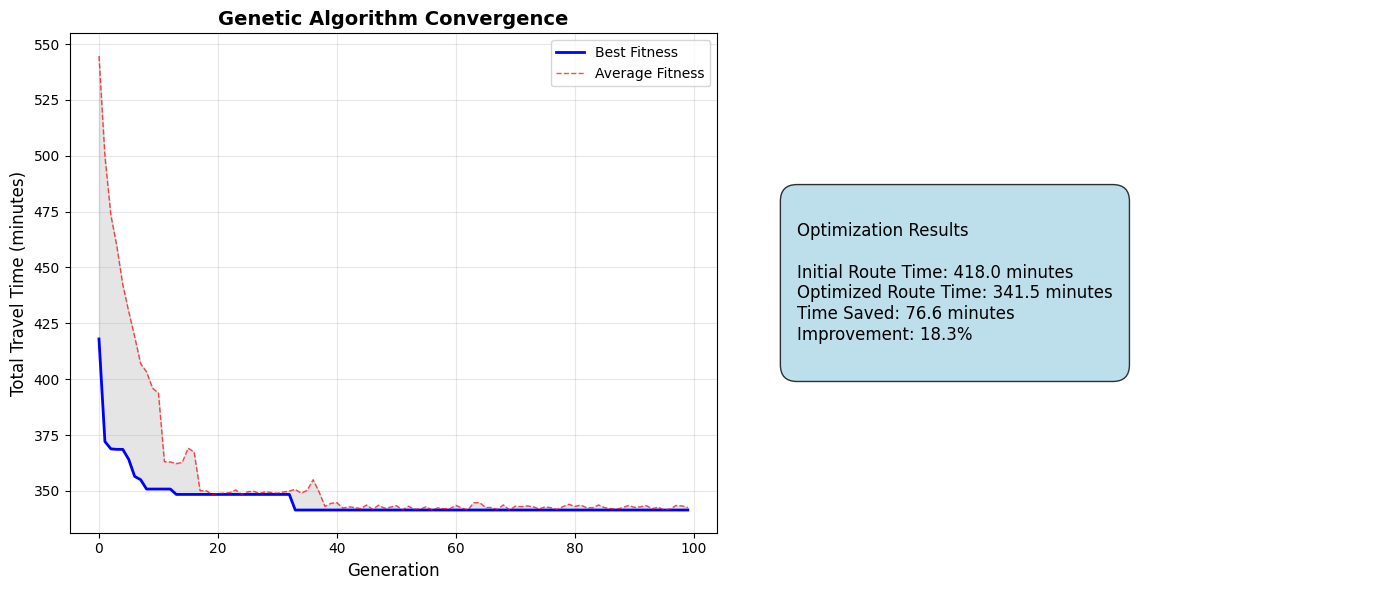

In [20]:
# Create performance visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Convergence plot
generations = range(len(fitness_history))
ax1.plot(generations, fitness_history, 'b-', linewidth=2, label='Best Fitness')
ax1.plot(generations, avg_history, 'r--', linewidth=1, alpha=0.7, label='Average Fitness')
ax1.fill_between(generations, fitness_history, avg_history, alpha=0.2, color='gray')
ax1.set_xlabel('Generation', fontsize=12)
ax1.set_ylabel('Total Travel Time (minutes)', fontsize=12)
ax1.set_title('Genetic Algorithm Convergence', fontsize=14, weight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Improvement analysis
improvement_data = {
    'Initial Time': fitness_history[0],
    'Final Time': best_time,
    'Time Saved': fitness_history[0] - best_time,
    'Improvement %': (fitness_history[0] - best_time) / fitness_history[0] * 100
}

ax2.axis('off')
improvement_text = f"""
Optimization Results

Initial Route Time: {improvement_data['Initial Time']:.1f} minutes
Optimized Route Time: {improvement_data['Final Time']:.1f} minutes
Time Saved: {improvement_data['Time Saved']:.1f} minutes
Improvement: {improvement_data['Improvement %']:.1f}%
"""

ax2.text(0.1, 0.5, improvement_text, fontsize=12, 
         verticalalignment='center',
         bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.savefig('../data/ga_optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Build complete route with coordinates
route_details = []
route_coordinates = []

# Starting from depot
route_coordinates.append((STARTING_POINT['lat'], STARTING_POINT['lon']))

print("\nOptimized Route Sequence:")
print("="*60)
print(f"0. START: {STARTING_POINT['name']}")
print(f"   📍 ({STARTING_POINT['lat']:.4f}, {STARTING_POINT['lon']:.4f})")
print(f"   ⏱️ Time to first stop: {time_matrix[0][best_route[0]]:.1f} min")

# Add each stop
cumulative_time = 0
for i, location_idx in enumerate(best_route):
    location = locations_subset.iloc[location_idx - 1]
    weather = weather_data.get(location_idx, {})
    
    # Time from previous
    if i == 0:
        travel_time = time_matrix[0][location_idx]
    else:
        travel_time = time_matrix[best_route[i-1]][location_idx]
    
    cumulative_time += travel_time
    
    route_coordinates.append((location['Latitude'], location['Longitude']))
    
    route_details.append({
        'sequence': i + 1,
        'location_id': location_idx,
        'store_name': location['Store Name'],
        'address': location['Street Address'],
        'latitude': location['Latitude'],
        'longitude': location['Longitude'],
        'weather_condition': weather.get('condition', 'Clear'),
        'temperature': weather.get('temperature', 25),
        'travel_time_from_previous': travel_time,
        'cumulative_time': cumulative_time
    })
    
    print(f"\n{i+1}. {location['Store Name']}")
    print(f"   📍 ({location['Latitude']:.4f}, {location['Longitude']:.4f})")
    print(f"   🌤️ {weather.get('condition', 'Clear')}, {weather.get('temperature', 25):.1f}°C")
    print(f"   ⏱️ Time from previous: {travel_time:.1f} min")
    print(f"   ⏱️ Cumulative time: {cumulative_time:.1f} min")

# Return to depot
return_time = time_matrix[best_route[-1]][0]
cumulative_time += return_time
route_coordinates.append((STARTING_POINT['lat'], STARTING_POINT['lon']))

print(f"\nRETURN TO START: {STARTING_POINT['name']}")
print(f"   ⏱️ Return time: {return_time:.1f} min")
print(f"\n{'='*60}")
print(f"TOTAL ROUTE TIME: {cumulative_time:.1f} minutes ({cumulative_time/60:.2f} hours)")

# Save route details
route_df = pd.DataFrame(route_details)
route_df.to_csv('../data/optimized_route_details.csv', index=False)

# Save coordinates for GPS
coords_df = pd.DataFrame(route_coordinates, columns=['latitude', 'longitude'])
coords_df.to_csv('../data/route_coordinates_sequence.csv', index=False)




Optimized Route Sequence:
0. START: Central Depot
   📍 (19.0760, 72.8777)
   ⏱️ Time to first stop: 49.6 min

1. Nariman Point
   📍 (18.9300, 72.8200)
   🌤️ Mist, 29.4°C
   ⏱️ Time from previous: 49.6 min
   ⏱️ Cumulative time: 49.6 min

2. Fort
   📍 (18.9300, 72.8300)
   🌤️ Mist, 29.4°C
   ⏱️ Time from previous: 15.8 min
   ⏱️ Cumulative time: 65.4 min

3. Prabhadevi
   📍 (19.0100, 72.8200)
   🌤️ Mist, 29.4°C
   ⏱️ Time from previous: 25.3 min
   ⏱️ Cumulative time: 90.7 min

4. Bandra West - Chapel road
   📍 (19.0500, 72.8300)
   🌤️ Mist, 29.4°C
   ⏱️ Time from previous: 18.8 min
   ⏱️ Cumulative time: 109.6 min

5. Santacruz West
   📍 (19.0800, 72.8300)
   🌤️ Mist, 29.4°C
   ⏱️ Time from previous: 18.4 min
   ⏱️ Cumulative time: 128.0 min

6. Andheri West - Four Bunglows
   📍 (19.1300, 72.8200)
   🌤️ Mist, 29.4°C
   ⏱️ Time from previous: 31.0 min
   ⏱️ Cumulative time: 159.0 min

7. Andheri West - Infiniti Mall
   📍 (19.1400, 72.8300)
   🌤️ Mist, 29.4°C
   ⏱️ Time from previous: 9

In [23]:
def create_final_route_map(route, locations, starting_point, time_matrix, weather_conditions):
    """Create the final route map with all features"""
    
    # Calculate center
    all_lats = [starting_point['lat']] + list(locations['Latitude'])
    all_lons = [starting_point['lon']] + list(locations['Longitude'])
    center_lat = np.mean(all_lats)
    center_lon = np.mean(all_lons)
    
    # Create map with Google-style base
    route_map = folium.Map(
        location=[center_lat, center_lon], 
        zoom_start=12,
        tiles='cartodbpositron'
    )
    
    # Add starting point
    folium.Marker(
        location=[starting_point['lat'], starting_point['lon']],
        popup=folium.Popup(
            f"<b>{starting_point['name']}</b><br>"
            f"Type: Starting Point / Depot<br>"
            f"Coordinates: ({starting_point['lat']:.4f}, {starting_point['lon']:.4f})",
            max_width=300
        ),
        tooltip="Starting Point",
        icon=folium.Icon(color='red', icon='home', prefix='fa')
    ).add_to(route_map)
    
    # Add route stops
    for i, location_idx in enumerate(route):
        location = locations.iloc[location_idx - 1]
        weather = weather_conditions.get(location_idx, {})
        
        # Weather-based coloring
        if weather.get('condition', '') in ['Rain', 'Heavy rain', 'Thunderstorm']:
            marker_color = 'darkred'
            weather_icon = '🌧️'
        elif weather.get('condition', '') in ['Cloudy', 'Overcast']:
            marker_color = 'gray'
            weather_icon = '☁️'
        else:
            marker_color = 'green'
            weather_icon = '☀️'
        
        # Calculate times
        if i == 0:
            time_from_prev = time_matrix[0][location_idx]
        else:
            time_from_prev = time_matrix[route[i-1]][location_idx]
        
        popup_html = f"""
        <div style='font-family: Arial; width: 280px;'>
            <h4>Stop {i + 1}: {location['Store Name']}</h4>
            <hr>
            <b>Address:</b> {location['Street Address']}<br>
            <b>Coordinates:</b> ({location['Latitude']:.4f}, {location['Longitude']:.4f})<br>
            <hr>
            <b>Weather {weather_icon}:</b> {weather.get('condition', 'Clear')}<br>
            <b>Temperature:</b> {weather.get('temperature', 25):.1f}°C<br>
            <b>Travel time from previous:</b> {time_from_prev:.1f} min<br>
        </div>
        """
        
        # Location marker
        folium.Marker(
            location=[location['Latitude'], location['Longitude']],
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=f"Stop {i + 1}: {location['Store Name']}",
            icon=folium.Icon(color=marker_color, icon='coffee', prefix='fa')
        ).add_to(route_map)
        
        # Number overlay
        folium.Marker(
            location=[location['Latitude'], location['Longitude']],
            icon=folium.DivIcon(
                html=f'''<div style="
                    font-size: 14px; 
                    font-weight: bold; 
                    color: white; 
                    background-color: #007bff; 
                    width: 30px; 
                    height: 30px; 
                    border-radius: 50%; 
                    text-align: center; 
                    line-height: 30px; 
                    border: 3px solid white;
                    box-shadow: 0 2px 6px rgba(0,0,0,0.3);
                    margin-left: -15px;
                    margin-top: -40px;
                    ">{i + 1}</div>'''
            )
        ).add_to(route_map)
    
    # Draw route lines
    waypoints = [[starting_point['lat'], starting_point['lon']]]
    for idx in route:
        loc = locations.iloc[idx - 1]
        waypoints.append([loc['Latitude'], loc['Longitude']])
    waypoints.append([starting_point['lat'], starting_point['lon']])
    
    # Create route segments with different colors based on travel time
    for i in range(len(waypoints) - 1):
        start_point = waypoints[i]
        end_point = waypoints[i + 1]
        
        # Get travel time for this segment
        if i == 0:
            segment_time = time_matrix[0][route[0]]
        elif i == len(route):
            segment_time = time_matrix[route[-1]][0]
        else:
            segment_time = time_matrix[route[i-1]][route[i]]
        
        # Color based on time
        if segment_time > 30:
            color = '#DC143C'  # Crimson for slow
            weight = 6
        elif segment_time > 20:
            color = '#FF8C00'  # Dark orange for moderate
            weight = 5
        else:
            color = '#228B22'  # Forest green for fast
            weight = 4
        
        # Special style for return journey
        if i == len(route):
            color = '#9370DB'  # Purple
            dash_array = '10, 5'
        else:
            dash_array = None
        
        # Draw line
        folium.PolyLine(
            locations=[start_point, end_point],
            color=color,
            weight=weight,
            opacity=0.8,
            dash_array=dash_array,
            popup=f"Segment {i+1}: {segment_time:.1f} minutes"
        ).add_to(route_map)
        
        # Add animated ant path for better visibility
        AntPath(
            locations=[start_point, end_point],
            color=color,
            weight=2,
            opacity=0.4,
            delay=800,
            dash_array=[10, 20]
        ).add_to(route_map)
    
    # Create Google Maps URL for navigation
    gmaps_url = "https://www.google.com/maps/dir/"
    for wp in waypoints:
        gmaps_url += f"{wp[0]},{wp[1]}/"
    
    return route_map

# Create final map
print("Creating final optimized route map...")
final_map = create_final_route_map(
    best_route, locations_subset, STARTING_POINT, time_matrix, weather_data
)
final_map


Creating final optimized route map...


In [25]:
# Generate final comprehensive report
report = {
    'metadata': {
        'generated_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'algorithm': 'Genetic Algorithm + XGBoost with Real-time Data',
        'considers_traffic': True,
        'considers_weather': True,
        'total_locations': len(best_route),
        'starting_point': STARTING_POINT
    },
    'route_summary': {
        'total_travel_time_minutes': best_time,
        'total_travel_time_hours': best_time / 60,
        'optimization_improvement': f"{(fitness_history[0] - best_time) / fitness_history[0] * 100:.1f}%",
        'total_stops': len(best_route)
    },
    'model_performance': {
        'xgboost_r2_score': r2,
        'xgboost_rmse': rmse,
        'xgboost_mae': mae,
        'training_samples': len(training_df)
    },
    'route_details': route_details,
    'coordinates_sequence': [
        {'lat': coord[0], 'lon': coord[1]} 
        for coord in route_coordinates
    ],
    'weather_conditions': {
        str(k): v for k, v in weather_data.items()
    }
}

# Save report
with open('../data/final_route_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("\n" + "="*70)
print("ROUTE OPTIMIZATION COMPLETE!")
print("="*70)
print(f"\n📊 Algorithm: Genetic Algorithm + XGBoost")
print(f"🏠 Starting Point: {STARTING_POINT['name']}")
print(f"📍 Total Stops: {len(best_route)}")
print(f"⏱️  Total Time: {best_time:.1f} minutes ({best_time/60:.2f} hours)")
print(f"📈 Optimization: {(fitness_history[0] - best_time) / fitness_history[0] * 100:.1f}% improvement")
print(f"🎯 Model Accuracy: R² = {r2:.3f}")
print(f"\n✅ Factors Considered:")
print("   • Real-time traffic conditions (Google Distance Matrix)")
print("   • Current weather at each location (WeatherAPI)")
print("   • Machine learning predictions (XGBoost)")
print("   • Genetic algorithm optimization")




ROUTE OPTIMIZATION COMPLETE!

📊 Algorithm: Genetic Algorithm + XGBoost
🏠 Starting Point: Central Depot
📍 Total Stops: 10
⏱️  Total Time: 341.5 minutes (5.69 hours)
📈 Optimization: 18.3% improvement
🎯 Model Accuracy: R² = 0.929

✅ Factors Considered:
   • Real-time traffic conditions (Google Distance Matrix)
   • Current weather at each location (WeatherAPI)
   • Machine learning predictions (XGBoost)
   • Genetic algorithm optimization


### Testing the model on co-ordinates provided by user

In [ ]:
def optimize_custom_route(delivery_locations, starting_point_input):
    
    print(f"Optimizing route for {len(delivery_locations)} delivery locations")
    print(f"Starting from: {starting_point_input['name']}")
    
    # Create DataFrame for locations
    user_df = pd.DataFrame([
        {
            'Latitude': lat, 
            'Longitude': lon, 
            'Store Name': f'Location {i+1}',
            'Street Address': f'User Location {i+1}'
        }
        for i, (lat, lon) in enumerate(delivery_locations)
    ])
    
    # Create distance matrix
    print("Creating distance matrix with real-time data...")
    dist_matrix_user, time_matrix_user, weather_user = create_optimized_distance_matrix(
        user_df, starting_point_input, xgb_model, scaler
    )
    
    # Run optimization
    print("Running route optimization...")
    ga_user = GeneticAlgorithmTSP(time_matrix_user, weather_user)
    optimized_route, total_time, _, _ = ga_user.optimize(
        population_size=100,
        generations=50,
        verbose=False
    )
    
    # Build coordinate sequence
    optimized_coordinates = []
    
    # Start
    optimized_coordinates.append({
        'type': 'start',
        'name': starting_point_input['name'],
        'lat': starting_point_input['lat'],
        'lon': starting_point_input['lon']
    })
    
    # Delivery locations in optimized order
    for i, idx in enumerate(optimized_route):
        lat, lon = delivery_locations[idx - 1]
        optimized_coordinates.append({
            'type': 'delivery',
            'sequence': i + 1,
            'name': f'Delivery Location {idx}',
            'lat': lat,
            'lon': lon
        })
    
    # Return to start
    optimized_coordinates.append({
        'type': 'end',
        'name': f"{starting_point_input['name']} (Return)",
        'lat': starting_point_input['lat'],
        'lon': starting_point_input['lon']
    })
    
    print(f"\nOptimization complete!")
    print(f"Total travel time: {total_time:.1f} minutes ({total_time/60:.2f} hours)")
    
    return optimized_coordinates, total_time

# Example usage
example_starting = {
    'name': 'Custom Warehouse',
    'lat': 22.290346737221387,                      
    'lon': 73.36307811168795
}

example_deliveries = [
    (22.326296504557796, 73.23534874896336),  
    (22.287545669556454, 73.197583247974),  
    (22.352336102186445, 73.20994286647961),  
    (22.336458877334163, 73.19689660250147),  
    (22.314862950347727, 73.19552331155639),  
    (22.329472325583737, 73.16668420170996), 
    (22.351065990754346, 73.17492394738036),
    (22.302793182679103, 73.1673708471825),
    (22.285004255633613, 73.15295129225926)
]

print("Example: Optimizing custom delivery route...")
custom_coords, custom_time = optimize_custom_route(example_deliveries, example_starting)

print("\nOptimized coordinate sequence:")
for coord in custom_coords:
    print(f"  {coord['type'].upper()}: {coord.get('name', '')} "
          f"({coord['lat']:.4f}, {coord['lon']:.4f})")


Example: Optimizing custom delivery route...
Optimizing route for 9 delivery locations
Starting from: Custom Warehouse
Creating distance matrix with real-time data...
Creating distance matrix for 9 locations + starting point...
Using XGBoost for travel time predictions with real-time traffic patterns...
  Progress: 50/100 calculations completed
  Progress: 100/100 calculations completed
Distance matrix created successfully!
Running route optimization...
Starting Genetic Algorithm optimization...
Population size: 100, Generations: 50

Optimization complete!
Total travel time: 267.0 minutes (4.45 hours)

Optimized coordinate sequence:
  START: Custom Warehouse (22.2903, 73.3631)
  DELIVERY: Delivery Location 5 (22.3149, 73.1955)
  DELIVERY: Delivery Location 4 (22.3365, 73.1969)
  DELIVERY: Delivery Location 3 (22.3523, 73.2099)
  DELIVERY: Delivery Location 7 (22.3511, 73.1749)
  DELIVERY: Delivery Location 6 (22.3295, 73.1667)
  DELIVERY: Delivery Location 8 (22.3028, 73.1674)
  DELIVE

In [ ]:
def create_custom_route_map(optimized_coordinates, total_time, starting_point_input):

    # Calculate map center
    all_lats = [coord['lat'] for coord in optimized_coordinates]
    all_lons = [coord['lon'] for coord in optimized_coordinates]
    center_lat = np.mean(all_lats)
    center_lon = np.mean(all_lons)
    
    # Create map
    custom_map = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='cartodbpositron'
    )
    
    # Add markers for each location
    delivery_count = 0
    for i, coord in enumerate(optimized_coordinates):
        if coord['type'] == 'start':
            # Starting point marker
            folium.Marker(
                location=[coord['lat'], coord['lon']],
                popup=folium.Popup(
                    f"<b>Starting Point</b><br>"
                    f"{coord['name']}<br>"
                    f"Coordinates: ({coord['lat']:.4f}, {coord['lon']:.4f})",
                    max_width=300
                ),
                tooltip="Starting Point",
                icon=folium.Icon(color='red', icon='home', prefix='fa')
            ).add_to(custom_map)
            
        elif coord['type'] == 'delivery':
            delivery_count += 1
            
            # Get weather for this location
            weather = get_weather_data(coord['lat'], coord['lon'])
            
            # Determine color based on weather
            if weather['condition'] in ['Rain', 'Heavy rain', 'Thunderstorm']:
                color = 'darkred'
                weather_icon = '🌧️'
            elif weather['condition'] in ['Cloudy', 'Overcast']:
                color = 'gray'
                weather_icon = '☁️'
            else:
                color = 'green'
                weather_icon = '☀️'
            
            # Delivery location marker
            popup_html = f"""
            <div style='font-family: Arial; width: 250px;'>
                <h4>Stop {delivery_count}: {coord['name']}</h4>
                <hr>
                <b>Coordinates:</b> ({coord['lat']:.4f}, {coord['lon']:.4f})<br>
                <b>Weather {weather_icon}:</b> {weather['condition']}<br>
                <b>Temperature:</b> {weather['temperature']:.1f}°C<br>
                <b>Humidity:</b> {weather['humidity']}%<br>
            </div>
            """
            
            folium.Marker(
                location=[coord['lat'], coord['lon']],
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=f"Stop {delivery_count}: {coord['name']}",
                icon=folium.Icon(color=color, icon='map-marker', prefix='fa')
            ).add_to(custom_map)
            
            # Add number marker
            folium.Marker(
                location=[coord['lat'], coord['lon']],
                icon=folium.DivIcon(
                    html=f'''<div style="
                        font-size: 14px;
                        font-weight: bold;
                        color: white;
                        background-color: #007bff;
                        width: 30px;
                        height: 30px;
                        border-radius: 50%;
                        text-align: center;
                        line-height: 30px;
                        border: 3px solid white;
                        box-shadow: 0 2px 6px rgba(0,0,0,0.3);
                        margin-left: -15px;
                        margin-top: -40px;
                    ">{delivery_count}</div>'''
                )
            ).add_to(custom_map)
    
    # Draw route lines
    route_points = [[coord['lat'], coord['lon']] for coord in optimized_coordinates]
    
    # Create segments with different colors
    for i in range(len(route_points) - 1):
        start = route_points[i]
        end = route_points[i + 1]
        
        # Estimate segment time (proportional to total time)
        segment_time = total_time / (len(route_points) - 1)
        
        # Color coding
        if i == len(route_points) - 2:  # Return journey
            color = '#9370DB'  # Purple
            dash_array = '10, 5'
            weight = 5
        else:
            # Color based on estimated time
            if segment_time > 25:
                color = '#DC143C'  # Crimson
                weight = 6
            elif segment_time > 15:
                color = '#FF8C00'  # Orange
                weight = 5
            else:
                color = '#228B22'  # Green
                weight = 4
            dash_array = None
        
        # Draw route line
        folium.PolyLine(
            locations=[start, end],
            color=color,
            weight=weight,
            opacity=0.8,
            dash_array=dash_array,
            popup=f"Segment {i+1}"
        ).add_to(custom_map)
        
        # Add animated ant path
        AntPath(
            locations=[start, end],
            color=color,
            weight=2,
            opacity=0.4,
            delay=800,
            dash_array=[10, 20]
        ).add_to(custom_map)
        
        # Add direction arrow
        mid_lat = (start[0] + end[0]) / 2
        mid_lon = (start[1] + end[1]) / 2
        
        # Calculate arrow angle
        angle = np.arctan2(end[1] - start[1], end[0] - start[0]) * 180 / np.pi
        
        folium.RegularPolygonMarker(
            location=[mid_lat, mid_lon],
            number_of_sides=3,
            radius=8,
            rotation=angle - 90,
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.6,
            weight=2
        ).add_to(custom_map)
    
    # Create Google Maps URL
    gmaps_url = "https://www.google.com/maps/dir/"
    for point in route_points:
        gmaps_url += f"{point[0]},{point[1]}/"
        
    
    return custom_map

# Create map for the example custom route
print("Creating map for custom route...")
custom_route_map = create_custom_route_map(custom_coords, custom_time, example_starting)


# Display the map
custom_route_map


Creating map for custom route...
